# Guided Project: Analyzing NYC High School Data

For a brief bit of background, the SAT, or Scholastic Aptitude Test, is a test that high school seniors in the U.S. take every year. The SAT has three sections, each of which is worth a maximum of 800 points. Colleges use the SAT to determine which students to admit. High average SAT scores are usually indicative of a good school.

New York City has published data on student SAT scores by high school, along with additional demographic data sets. Over the last three missions, we combined the following data sets into a single, clean pandas dataframe:

* **SAT scores by school** - SAT scores for each high school in New York City
* **School attendance** - Attendance information for each school in New York City
* **Class size** - Information on class size for each school
* **AP test results** - Advanced Placement (AP) exam results for each high school (passing an optional AP exam in a particular subject can earn a student college credit in that subject)
* **Graduation outcomes** - The percentage of students who graduated, and other outcome information
* **Demographics** - Demographic information for each school
* **School survey** - Surveys of parents, teachers, and students at each school

New York City has a significant immigrant population and is very diverse, so comparing demographic factors such as race, income, and gender with SAT scores is a good way to determine whether the SAT is a fair test. For example, if certain racial groups consistently perform better on the SAT, we would have some evidence that the SAT is unfair.

In the last mission, we began performing some analysis. We'll extend that analysis in this mission. As you can see, we've included the code to read in all of the data, combine it, and create correlations in the notebook. If you'd like to see the finished notebook that contains solutions for all of the steps, you can find it in the GitHub repo for this mission.

The dataframe combined contains all of the data we'll be using in our analysis.

# Read in the data

In [9]:
import pandas as pd
import numpy
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [86]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey
survey

,DBN,rr_s,rr_t,rr_p,N_s,N_t,N_p,saf_p_11,com_p_11,eng_p_11,...,eng_t_11,aca_t_11,saf_s_11,com_s_11,eng_s_11,aca_s_11,saf_tot_11,com_tot_11,eng_tot_11,aca_tot_11
0,01M015,NaN,88,60,NaN,22.0,90.0,8.5,7.6,7.5,...,7.6,7.9,NaN,NaN,NaN,NaN,8.0,7.7,7.5,7.9
1,01M019,NaN,100,60,NaN,34.0,161.0,8.4,7.6,7.6,...,8.9,9.1,NaN,NaN,NaN,NaN,8.5,8.1,8.2,8.4
2,01M020,NaN,88,73,NaN,42.0,367.0,8.9,8.3,8.3,...,6.8,7.5,NaN,NaN,NaN,NaN,8.2,7.3,7.5,8.0
3,01M034,89.0,73,50,145.0,29.0,151.0,8.8,8.2,8.0,...,6.8,7.8,6.2,5.9,6.5,7.4,7.3,6.7,7.1,7.9
4,01M063,NaN,100,60,NaN,23.0,90.0,8.7,7.9,8.1,...,7.8,8.1,NaN,NaN,NaN,NaN,8.5,7.6,7.9,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51,75X352,90.0,58,48,38.0,46.0,160.0,8.9,8.3,7.9,...,5.7,5.8,6.8,6.0,7.8,7.6,7.4,6.6,7.1,7.2
52,75X721,84.0,90,48,237.0,82.0,239.0,8.6,7.6,7.5,...,6.7,7.0,7.8,7.2,7.8,7.9,8.0,7.1,7.3,7.6
53,75X723,77.0,74,20,103.0,69.0,74.0,8.4,7.8,7.8,...,6.7,7.6,6.7,7.2,7.7,7.7,7.6,7.4,7.4,7.7
54,75X754,63.0,93,22,336.0,82.0,124.0,8.3,7.5,7.5,...,6.6,7.1,6.8,6.6,7.6,7.7,7.2,6.9,7.3,7.5


# Add DBN columns

In [11]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [12]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [13]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [14]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [76]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [16]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [244]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score    0.986820
SAT Math Avg. Score                0.972643
SAT Writing Avg. Score             0.987771
sat_score                          1.000000
AP Test Takers                     0.523140
                                     ...   
priority09                              NaN
priority10                              NaN
lat                               -0.121029
lon                               -0.132222
ap_per                             0.057171
Name: sat_score, Length: 68, dtype: float64


# Plotting survey correlations

In [79]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

#### Instructions
1. Set up matplotlib to work in Jupyter notebook.
2. There are several fields in `combined` that originally came from a survey of parents, teachers, and students. Make a bar plot of the correlations between these fields and `sat_score`.
    * You can find a list of the fields in the `survey_fields` variable in the notebook.
3. Consult the data dictionary that's part of the `zip` file you can download from the City of New York's website.
    * Did you find any surprising correlations?
4. Write up your results in a Markdown cell.

In [269]:
import matplotlib.pyplot as plt
# %matplotlib inline

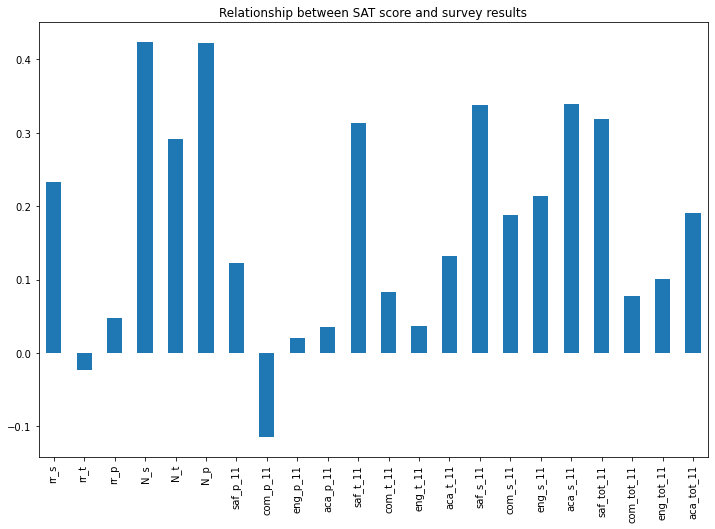

In [270]:
# There are several fields in combined that originally came from a survey of parents, teachers, and students. Make a bar plot of the correlations between these fields and sat_score.
# You can find a list of the fields in the survey_fields variable in the notebook.

plot_title = "Relationship between SAT score and survey results"
correlations[survey_fields].plot.bar(figsize = (12, 8), title = plot_title)
plt.show()

#### Observation 
##### Consult the data dictionary that's part of the zip file you can download from the City of New York's website.
##### Did you find any surprising correlations?
##### Write up your results in a Markdown cell.
- N_s and N_p moderately affect the SAT score and cause an increase in the SAT score as they increase. rr_t and com_p_11 cause the SAT score to drop as they increase.

In the last cell, you may have noticed that `saf_t_11` and `saf_s_11`, which measure how teachers and students perceive safety at school, correlated highly with `sat_score`. In the next cell, we'll dig into this relationship a bit more, and try to figure out which schools have low safety scores.

#### Instructions

1. Investigate safety scores.
    * Make a scatter plot of the `saf_s_11` column vs. the `sat_score` in `combined`.
    * Write up your conclusions about safety and SAT scores in a Markdown cell.
2. Compute safety scores.
    * Compute the average safety score for each borough.
    * Write up your conclusions about safety by geographic area in a Markdown cell. You may want to read up on the boroughs of New York City.

### Investigate safety scores.

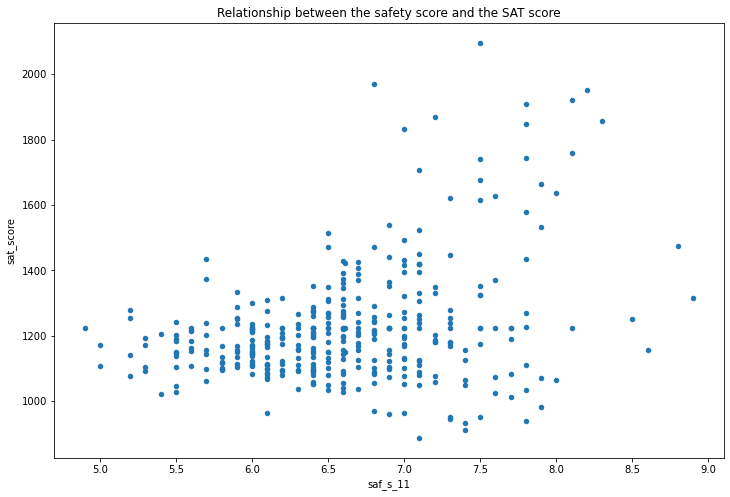

In [272]:
# Make a scatter plot of the saf_s_11 column vs. the sat_score in combined.

plot_title = "Relationship between the safety score and the SAT score"
combined.plot.scatter(x = "saf_s_11", y = "sat_score", figsize = (12, 8), title = plot_title)
plt.show()

#### Observation
##### Write up your conclusions about safety and SAT scores in a Markdown cell.
- It appears that the safety score and the SAT score are moderately related. For a few schools, the SAT score increases as the safety score increases and for a few others, safety score does not strongly affect the SAT score because it remains close to the average.

### Compute safety scores.

In [131]:
# Compute the average safety score for each borough.

x = combined.groupby("boro")["saf_s_11"].mean()
print(x)

boro
Bronx            6.606577
Brooklyn         6.370755
Manhattan        6.831370
Queens           6.721875
Staten Island    6.530000
Name: saf_s_11, dtype: float64


#### Observation
##### Write up your conclusions about safety by geographic area in a Markdown cell. You may want to read up on the boroughs of New York City.
- All the areas have safety scores that fall slightly below the average. However, Manhattan and Queens have the highest safety scores, and Brookyln has the least of them of.

There are a few columns that indicate the percentage of each race at a given school:

* `white_per`
* `asian_per`
* `black_per`
* `hispanic_per`

By plotting out the correlations between these columns and `sat_score`, we can determine whether there are any racial differences in SAT performance.

#### Instructions

1. Investigate racial differences in SAT scores.
    * Make a bar plot of the correlations between the columns above and `sat_score`.
    * Write up a Markdown cell containing your findings. Are there any unexpected correlations?
2. Explore schools with low SAT scores and high values for `hispanic_per`.
    * Make a scatter plot of `hispanic_per` vs. `sat_score`.
    * What does the scatter plot show? Record any interesting observations in a Markdown cell.
3. Research any schools with a `hispanic_per` greater than `95%`.
    * Find the school names in the data.
    * Use Wikipedia and Google to research the schools by name.
    * Is there anything interesting about these particular schools? Record your findings in a Markdown cell.
4. Research any schools with a `hispanic_per` less than `10%` and an average SAT score greater than `1800`.
    * Find the school names in the data.
    * Use Wikipedia and Google to research the schools by name.
    * Is there anything interesting about these particular schools?Record your findings in a Markdown cell.

### Investigate racial differences in SAT scores.

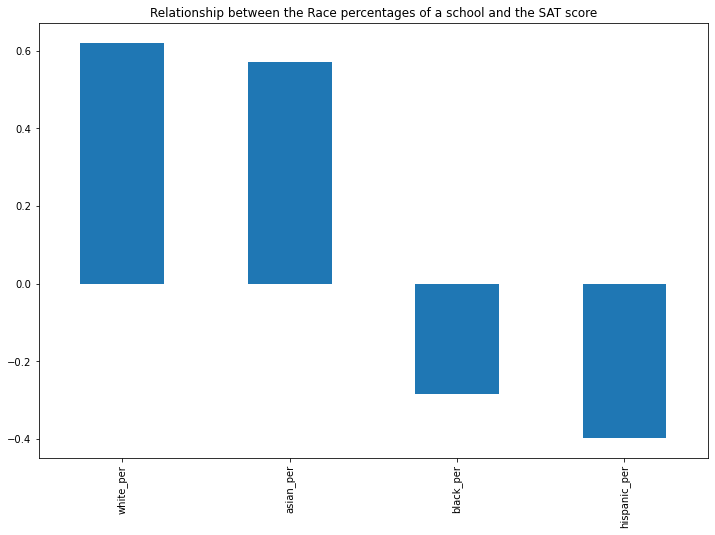

In [273]:
# Make a bar plot of the correlations between the columns above and sat_score.

plot_title = "Relationship between the Race percentages of a school and the SAT score"
race_per = ["white_per", "asian_per", "black_per", "hispanic_per"]
race_score_corr = correlations[race_per]
race_score_corr.plot.bar(figsize = (12, 8), title = plot_title)
plt.show()

#### Observation
##### Write up a Markdown cell containing your findings. Are there any unexpected correlations?
- The percentage of white and asian students affects the SAT score of a school. The higher the percentages, the higher the SAT score. Whereas the SAT scores slightly drop when the percentage of black and hispanic students increase.

### Explore schools with low SAT scores and high values for hispanic_per

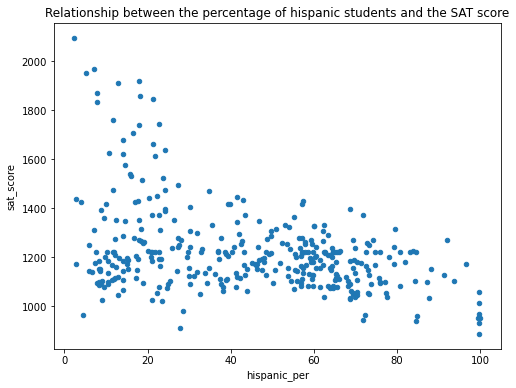

In [290]:
# Make a scatter plot of hispanic_per vs. sat_score.

plot_title = "Relationship between the percentage of hispanic students and the SAT score"
combined.plot.scatter(x = "hispanic_per", y = "sat_score", figsize = (8, 6), title = plot_title)
plt.show()

#### Observation
##### What does the scatter plot show? Record any interesting observations in a Markdown cell.
- There is strong negative correlationship between the 2 fields. It therefore appears that as the percentage of hispanics in a school increases, the SAT score decreases. 

### Research any schools with a hispanic_per greater than 95%.

In [164]:
# Find the school names in the data.

high_hispanic_per = combined[combined["hispanic_per"]  > 95]
high_hispanic_per["SCHOOL NAME"]

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

#### Observation
##### Use Wikipedia and Google to research the schools by name.
##### Is there anything interesting about these particular schools? Record your findings in a Markdown cell.

- The listed schools are public schools that primarily focus on developing student English proficiency, and have a high mean percentage of English learners. This could explain why many of them tend to score less in the SAT's, as English is vital in passing the reading and writing tests.

### Research any schools with a hispanic_per less than 10% and an average SAT score greater than 1800.

In [292]:
# Find the school names in the data.

low_hispanic_per = combined[(combined["hispanic_per"]  < 10) & (combined["sat_score"]  > 1800)]
low_hispanic_per["SCHOOL NAME"]

37                                STUYVESANT HIGH SCHOOL
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

##### Use Wikipedia and Google to research the schools by name.
##### Is there anything interesting about these particular schools?
- The listed schools determine student admissions based on the Specialized High Schools Admissions Test (SHSAT)

There are two columns that indicate the percentage of each gender at a school:

* `male_per`
* `female_per`
We can plot out the correlations between each percentage and `sat_score`.

#### Instructions

1. Investigate gender differences in SAT scores.
    * Make a bar plot of the correlations between the columns above and `sat_score`.
    * Record your findings in a Markdown cell. Are there any unexpected correlations?
2. Investigate schools with high SAT scores and a high `female_per`.
    * Make a scatter plot of `female_per` vs. `sat_score`.
    * What does the scatter plot show? Record any interesting observations in a Markdown cell.
3. Research any schools with a `female_per` greater than `60%` and an average SAT score greater than `1700`.
    * Find the school names in the data.
    * Use Wikipedia and Google to research the schools by name.
    * Is there anything interesting about these particular schools? Record your findings in a Markdown cell.

### Investigate gender differences in SAT scores.

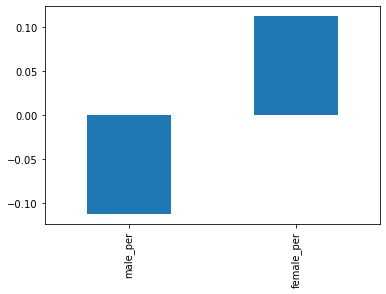

In [175]:
# Make a bar plot of the correlations between the columns above and sat_score.
gender_per = ["male_per", "female_per"]
gender_score_corr = correlations[gender_per]
gender_score_corr.plot.bar()
plt.show()

#### Observation
##### Record your findings in a Markdown cell. Are there any unexpected correlations?
- There is a weak relationship between the sat score and the student genders. Gender does not strongly affect the sat score.

### Investigate schools with high SAT scores and a high female_per.

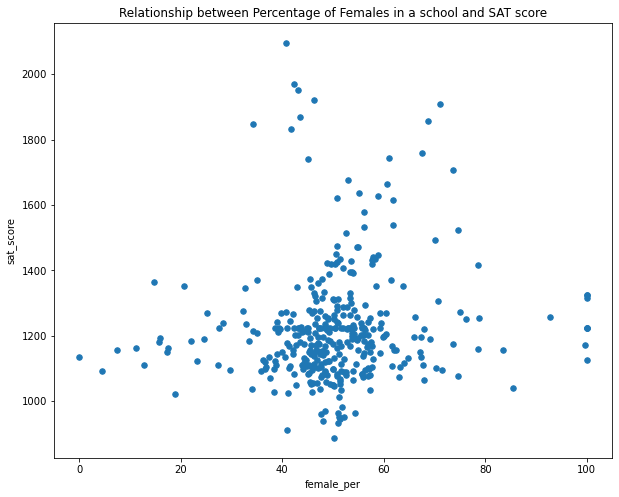

In [287]:
# Make a scatter plot of female_per vs. sat_score.

plot_title = "Relationship between Percentage of Females in a school and SAT score"
combined.plot.scatter(x = "female_per", y = "sat_score", s = 30, figsize = (10, 8), title = plot_title)
plt.show()

#### Observation
#####  What does the scatter plot show? Record any interesting observations in a Markdown cell.
There is no obvious relationship between the SAT score and the percentage of females per school. However, for schools with 40 to 60 female students, many of them score below average and just a few score above average.

### Research any schools with a female_per greater than 60% and an average SAT score greater than 1700.

In [188]:
# Find the school names in the data.

high_female_per = combined[(combined["female_per"] > 60) & (combined["sat_score"] > 1700)]
high_female_per["SCHOOL NAME"]

5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

#### Observation
##### Use Wikipedia and Google to research the schools by name.
##### Is there anything interesting about these particular schools? Record your findings in a Markdown cell.
- These schools appear to be very selective in nature; taking in students who are expectional.

In the U.S., high school students take Advanced Placement (AP) exams to earn college credit. There are AP exams for many different subjects.

It makes sense that the number of students at a school who took AP exams would be highly correlated with the school's SAT scores. Let's explore this relationship. Because `total_enrollment` is highly correlated with `sat_score`, we don't want to bias our results. Instead, we'll look at the percentage of students in each school who took at least one AP exam.

#### Instructions

1. Calculate the percentage of students in each school that took an AP exam.
    * Divide the `AP Test Takers ` column by the `total_enrollment` column.
        * The column name `AP Test Takers ` has a space at the end --*don't forget to add it!*
    * Assign the result to the `ap_per` column.
2. Investigate the relationship between AP scores and SAT scores.
    * Make a scatter plot of `ap_per` vs. `sat_score`.
    * What does the scatter plot show? Record any interesting observations in a Markdown cell.

### Calculate the percentage of students in each school that took an AP exam.

In [228]:
# Divide the AP Test Takers column by the total_enrollment column.
# The column name AP Test Takers has a space at the end --don't forget to add it!
# Assign the result to the ap_per column.

ap_per = combined["AP Test Takers "] / combined["total_enrollment"] 
combined["ap_per"] = ap_per

### Investigate the relationship between AP scores and SAT scores.

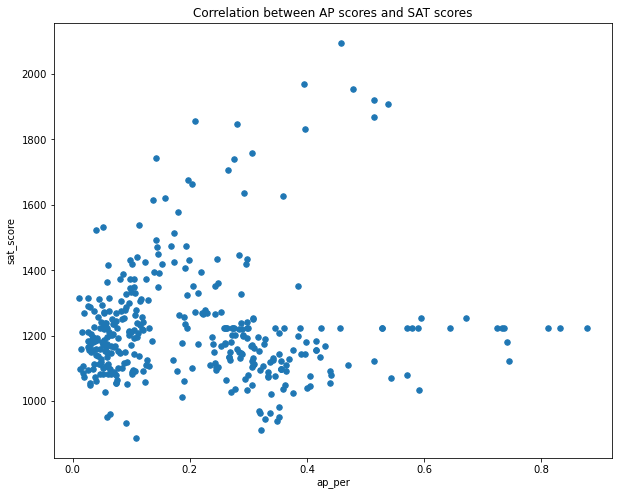

In [288]:
# Make a scatter plot of ap_per vs. sat_score.

plot_title = "Correlation between AP scores and SAT scores"
combined.plot.scatter(x = "ap_per", y = "sat_score", s = 30, figsize = (10, 8), title = plot_title)
plt.show()

#### Observation
##### What does the scatter plot show? Record any interesting observations in a Markdown cell.
- There is no obvious relationship between the AP scores and the SAT score

## Good Job!!!